![](./resources/System_v1_cropland.png)

### Introduction

This notebook contains a short demo on how to use the WorldCereal system to generate a cropland extent map for your area and season of interest.<br>
The map is generated using a default model trained by the WorldCereal consortium to distinguish cropland from all other land use.


<div class="alert alert-block alert-info">
<b>Cropland definition:</b> 
Cropland is defined here as land used for temporary crops, i.e. crops with a less-than-1-year growing cycle which must be newly sown or planted for further production after the harvest. Sugar cane, asparagus, and cassava are also considered temporary crops, even though they remain in the field for more than 1 year. This cropland definition thus excludes perennial crops as well as (temporary) pastures.
</div>

### Content
  
- [Before you start](###-Before-you-start)
- [1. Define your region of interest](#1.-Define-your-region-of-interest)
- [2. Define your year of interest](#2.-Define-your-year-of-interest)
- [3. Set some other options](#3.-Set-some-other-options)
- [4. Generate your map](#4.-Generate-your-map)
- [5. Final notes](#5.-Final-notes)

### Before you start

In order to run WorldCereal crop mapping jobs from this notebook, you need to create an account on the [Copernicus Data Space Ecosystem](https://dataspace.copernicus.eu/).
This is free of charge and will grant you a number of free openEO processing credits to continue this demo.

### 1. Define your region of interest

When running the code snippet below, an interactive map will be visualized.
Click the Rectangle button on the left hand side of the map to start drawing your region of interest.
The widget will automatically store the coordinates of the last rectangle you drew on the map.

<div class="alert alert-block alert-warning">
<b>Processing area limitation:</b><br> 
Processing areas beyond 2500 km² are currently not supported to avoid excessive credit usage and long processing times.<br>
Upon exceeding this limit, an error will be shown, and you will need to draw a new rectangle.

For testing purposes, we recommend you to select a small area (< 250 km²) in order to limit processing time and credit usage.

A run of 250 km² will typically consume 40 credits and last around 20 mins.<br>
A run of 750 km² will typically consume 90 credits and last around 50 mins.<br>
A run of 2500 km² will typically consume 250 credits and last around 1h 40 mins.
</div>

In [1]:
from worldcereal.utils.map import ui_map

map = ui_map(area_limit=2500)
map.show_map()

### 2. Define your year of interest

The default WorldCereal cropland model always uses a time series of exactly one year as input for the model.

However, instead of just using a calendar year (January 1st - December 31st), we recommend to define the exact start and end date of your time series, or processing period, based on the timing of the local growing seasons.

Take the following example for Western Europe, where we typically have a winter season (s1) and summer season (s2):

<p align="center">
<img src="./resources/Cropland_inference_choose_end_date.png" width="500"/>
</p>


The best timing to start and end the time series in this case would be October (green vertical line), as for both seasons this would result in nicely capturing the growing season within the time series. It would not make sense in this case to define the year from June to June (red vertical line), as you will miss the start of the summer season and the end of the winter season in your time series.

So if you would like to map temporary crops in Western Europe for the year 2021, we would recommend to define your processing period as October 1st 2020 - September 30th 2021.

In case you do not know the typical seasonality of crops in your area of interest, you can consult the WorldCereal crop calendars using the function below.

Note that in case your area of interest is located in an extremely heterogeneous part of the world, the WorldCereal seasons cannot be retrieved at the moment. As a fall-back, please consult the [USDA crop calendars](https://ipad.fas.usda.gov/ogamaps/cropcalendar.aspx).

2025-01-27 16:50:27.029 | INFO     | worldcereal.utils.map:get_processing_extent:170 - Your processing extent: (4.236603, 46.331758, 4.297028, 46.375359)


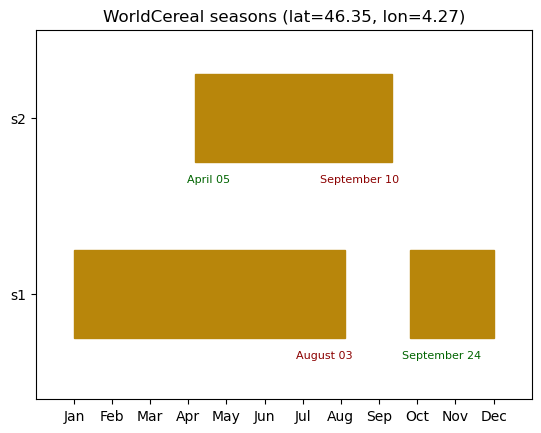

In [2]:
from notebook_utils.seasons import retrieve_worldcereal_seasons

spatial_extent = map.get_extent()
seasons = retrieve_worldcereal_seasons(spatial_extent)

Execute the next cell to select your processing period:

In [3]:
from notebook_utils.dateslider import date_slider

slider = date_slider()

### 3. Set some other options

In [ ]:
import os
from pathlib import Path
from notebook_utils.classifier import get_input

# Specify the local directory where the resulting maps should be downloaded to.
run = get_input('model run')
output_dir = Path(os.getcwd()) / f'CROPLAND_default_{run}'
print(f"Output directory: {output_dir}")

### 4. Generate your map

We now have all information we need to generate our map!<br>
The next cell will submit a map inference job on CDSE through OpenEO.<br>
The first time you run this, you will be asked to authenticate with your CDSE account by clicking the link provided below the cell.<br>
Then sit back and wait untill your map is ready...

In [ ]:
from worldcereal.job import generate_map, PostprocessParameters

processing_period = slider.get_processing_period()
processing_extent = map.get_extent()

# Launch the job on CDSE through OpenEO
results = generate_map(
    processing_extent,
    processing_period,
    output_dir=output_dir,
    postprocess_parameters=PostprocessParameters(),
)

In [ ]:
# The results contain the openeo job id...
print(f"Job id: {results.job_id}")
print(f"Location of metadata: {results.metadata}")
#... a list of products that were downloaded...
print(f"Products: {results.products.keys()}")
# ... for each product:
print('-- For each product --')
print(f"Type: {results.products['cropland']['type']}")
print(f"Temporal extent: {results.products['cropland']['temporal_extent']}")
print(f"Look-up table: {results.products['cropland']['lut']}")
print(f"URL: {results.products['cropland']['url']}")
print(f"Local path: {results.products['cropland']['path']}")

The classification results will be automatically downloaded to your *output_dir* in .tif format.<br>

The result will be a raster file containing two bands:
1. The label of the winning class
2. The probability of the winning class [0 - 100]

Using the function below, we split all this information into separate .tif files, thereby adding metadata and a color map, to ease interpretation and visualization:
- "cropland_classification_start-date_end-date.tif" --> contains the classification labels. The class look-up table is included in the .tif metadata.
- "cropland_probability_start-date_end-date.tif" -->  contains the probability associated with the predicted class

In [ ]:
from notebook_utils.visualization import prepare_visualization

filepaths = prepare_visualization(results)
filepaths

The resulting raster files can be visualized in QGIS.<br>
To get a quick idea of what the result looks like, you can use the cell below to plot the resulting map.

<div class="alert alert-block alert-danger">
<b>WARNING:</b> <br>
In case you run this notebook through the Terrascope environment, ALWAYS make sure you download the resulting files to your local system!<br>
The Terrascope environment will be cleaned automatically upon exit!
</div>

In [12]:
from notebook_utils.visualization import visualize_classification

visualize_classification(filepaths, "cropland")

### 5. Final notes

Both the quantity and quality of training data are main drivers affecting the quality of the cropland extent map.<br>
Using the figure below, you get a relative indication how much training data was available for training our current default cropland model:

<p align="center">
<img src="./resources/Landcover_training_data_density_PhI.png" width="700"/>
</p>

In case you own good quality reference data on land cover and/or crop types, consider contributing these data to the WorldCereal project through our [Reference Data Module](https://ewoc-rdm-ui.iiasa.ac.at/).